In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [1]:
import os
import random

from collections import OrderedDict
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tqdm import tqdm

from skimage.exposure import rescale_intensity
import skimage.io as io
from skimage.transform import resize, rescale, rotate
from sklearn.model_selection import train_test_split

import glob
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
import cv2

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Input
from tensorflow.keras.models import Model
from keras.layers import BatchNormalization, MaxPool2D, Add, UpSampling2D, Concatenate
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [ ]:
len("./image_data/p001_15678835/p001_15678845_")

In [2]:
data_map = []
for sub_dir_path in glob.glob("./image_data/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

df = pd.DataFrame({"patient_id" : data_map[::2], "path" : data_map[1::2]})
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [3]:


# File path line length images for later sorting
BASE_LEN = 41 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))

brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

Path to the Image: ./image_data/p013_30929181/p013_30929181_0023.tif 
Path to the Mask: ./image_data/p013_30929181/p013_30929181_0023_mask.png
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  817 non-null    object
 1   mask_path   817 non-null    object
 2   mask        817 non-null    object
dtypes: object(3)
memory usage: 19.3+ KB


In [4]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(443, 4)

In [5]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.2) # total x 0.2 = val 
X_test, X_val = train_test_split(X_val, test_size=0.5) # test = val x 0.5
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 354, valid size is 45 & test size is 44


In [6]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 640, img_w = 640, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

In [7]:
# Data generation for model input
train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [8]:
from dlv3p.model import Deeplabv3
deeplab_model = Deeplabv3(input_shape=(640, 640, 3), classes=2, backbone='xception', OS=16)
deeplab_model.summary()

16_separable_con
__________________________________________________________________________________________________
middle_flow_unit_16_separable_c (None, 40, 40, 728)  529984      middle_flow_unit_16_separable_con
__________________________________________________________________________________________________
middle_flow_unit_16_separable_c (None, 40, 40, 728)  2912        middle_flow_unit_16_separable_con
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 40, 40, 728)  0           middle_flow_unit_16_separable_con
__________________________________________________________________________________________________
middle_flow_unit_16_separable_c (None, 40, 40, 728)  6552        activation_58[0][0]              
__________________________________________________________________________________________________
middle_flow_unit_16_separable_c (None, 40, 40, 728)  2912        middle_flow_unit_16_separab

In [9]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalCrossentropy
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
deeplab_model.compile(optimizer = adam,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )


# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="DeeplabV3p-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [10]:
#### train start!!
###
##
#
with tf.device('/GPU:1'):
    h = deeplab_model.fit(train_data, 
                  epochs = 50, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9888
Epoch 00001: val_loss improved from inf to 0.09191, saving model to DeeplabV3p-segModel-weights.hdf5
22/22 [==============================] - 59s 3s/step - loss: 0.1132 - accuracy: 0.9888 - val_loss: 0.0919 - val_accuracy: 1.0000 - lr: 0.0500
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 1.0000
Epoch 00002: val_loss improved from 0.09191 to 0.07403, saving model to DeeplabV3p-segModel-weights.hdf5
22/22 [==============================] - 58s 3s/step - loss: 0.0583 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 1.0000 - lr: 0.0500
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9997
Epoch 00003: val_loss improved from 0.07403 to 0.06145, saving model to DeeplabV3p-segModel-weights.hdf5
22/22 [==============================] - 57s 3s/step - loss: 0.0366 - accuracy: 0.9997 - val_loss: 0.0614 - val_accuracy: 1

In [11]:
deeplab_model_json = deeplab_model.to_json()
with open("DeeplabV3p-seg-model.json", "w") as json_file:
    json_file.write(deeplab_model_json)

In [12]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

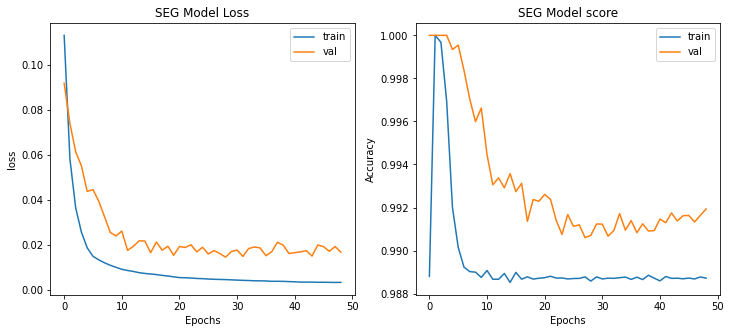

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("SEG Model score");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [14]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = deeplab_model.evaluate(test_data)
print("Segmentation accuracy is {:.2f}%".format(tv*100))

2/2 [==============================] - 0s 226ms/step - loss: 0.0194 - accuracy: 0.9936
Segmentation accuracy is 99.36%


In [15]:
def prediction(test, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        #img = io.imread(i)
        #normalizing
        #img = img *1./255.
        #reshaping
        #img = cv2.resize(img, (640,640))
        # converting img into array
        #img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        #img = np.reshape(img, (1,640,640,3))
        
        #making prediction for tumor in image
        #is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        #if np.argmax(is_defect)==0:
         #   image_id.append(i)
          #  has_mask.append(0)
           # mask.append('No mask :)')
            #continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,640,640,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (640,640))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [16]:
# making prediction
#df_pred = prediction(test, model, seg_model)
df_pred = prediction(X_test, deeplab_model)
df_pred

image_path  \
0   ./image_data/p003_30257453/p003_30257453_0017.tif   
1   ./image_data/p027_29942204/p027_29942204_0015.tif   
2   ./image_data/p011_30779476/p011_30779476_0011.tif   
3   ./image_data/p021_24537531/p021_24537531_0006.tif   
4   ./image_data/p004_29413822/p004_29413822_0012.tif   
5   ./image_data/p012_30741254/p012_30741254_0014.tif   
6   ./image_data/p002_19676162/p002_19676162_0013.tif   
7   ./image_data/p026_30881234/p026_30881234_0012.tif   
8   ./image_data/p018_12036866/p018_12036866_0010.tif   
9   ./image_data/p023_31300530/p023_31300530_0011.tif   
10  ./image_data/p027_29942204/p027_29942204_0016.tif   
11  ./image_data/p016_31119943/p016_31119943_0016.tif   
12  ./image_data/p015_31012693/p015_31012693_0020.tif   
13  ./image_data/p007_30484424/p007_30484424_0003.tif   
14  ./image_data/p009_30531243/p009_30531243_0020.tif   
15  ./image_data/p014_18063593/p014_18063593_0003.tif   
16  ./image_data/p003_30257453/p003_30257453_0004.tif   
17  ./image_data/p030_30703271/p030_30703271_0018.tif   
18  ./image_data/p010_18470277/p010_18470277_0013.tif   
19  ./image_data/p026_30881234/p026_30881234_0017.tif   
20  ./image_data/p018_12036866/p018_12036866_0022.tif   
21  ./image_data/p005_29922103/p005_29922103_0009.tif   
22  ./image_data/p030_30703271/p030_30703271_0006.tif   
23  ./image_data/p002_19676162/p002_19676162_0001.tif   
24  ./image_data/p004_29413822/p004_29413822_0019.tif   
25  ./image_data/p015_31012693/p015_31012693_0016.tif   
26  ./image_data/p025_30243251/p025_30243251_0012.tif   
27  ./image_data/p016_31119943/p016_31119943_0011.tif   
28  ./image_data/p012_30741254/p012_30741254_0013.tif   
29  ./image_data/p004_29413822/p004_29413822_0006.tif   
30  ./image_data/p029_30731525/p029_30731525_0008.tif   
31  ./image_data/p010_18470277/p010_18470277_0007.tif   
32  ./image_data/p030_30703271/p030_30703271_0019.tif   
33  ./image_data/p029_30731525/p029_30731525_0009.tif   
34  ./image_data/p014_18063593/p014_18063593_0015.tif   
35  ./image_data/p004_29413822/p004_29413822_0010.tif   
36  ./image_data/p008_28921970/p008_28921970_0013.tif   
37  ./image_data/p006_18154787/p006_18154787_0010.tif   
38  ./image_data/p025_30243251/p025_30243251_0018.tif   
39  ./image_data/p025_30243251/p025_30243251_0010.tif   
40  ./image_data/p011_30779476/p011_30779476_0009.tif   
41  ./image_data/p021_24537531/p021_24537531_0019.tif   
42  ./image_data/p007_30484424/p007_30484424_0008.tif   
43  ./image_data/p021_24537531/p021_24537531_0017.tif   

                                       predicted_mask  has_mask  
0   [[[[ 6.4168715 -4.845631 ], [ 6.2152324 -4.901...         1  
1   [[[[ 7.990166 -6.813694], [ 7.813399  -6.88031...         1  
2   [[[[ 5.8360357 -4.4236174], [ 5.664819  -4.351...         1  
3   [[[[ 4.7897944 -4.9769053], [ 4.5440845 -4.682...         1  
4   [[[[ 4.7866096 -5.2857256], [ 4.7836394 -5.199...         1  
5   [[[[ 6.854279  -5.9726353], [ 6.557792  -5.767...         1  
6   [[[[ 5.617297 -4.464389], [ 5.8532662 -4.58465...         1  
7   [[[[ 5.1055717 -3.7607698], [ 4.8723974 -3.663...         1  
8   [[[[ 6.1095386 -4.6305914], [ 5.9423156 -4.505...         1  
9   [[[[ 6.0822496 -3.7387922], [ 5.8748536 -3.692...         1  
10  [[[[ 8.3873625 -7.9925547], [ 8.024292 -8.0203...         1  
11  [[[[ 5.271651  -4.7545667], [ 5.2919354 -4.621...         1  
12  [[[[ 5.9206953 -4.6716294], [ 5.6038494 -4.760...         1  
13  [[[[ 5.1516056 -4.392603 ], [ 5.0045543 -4.330...         1  
14  [[[[ 5.825444  -5.8079295], [ 5.6225195 -5.707...         1  
15  [[[[ 6.0550385 -5.284323 ], [ 5.9723334 -5.428...         1  
16  [[[[ 4.721843  -4.9499297], [ 4.729295 -4.7324...         1  
17  [[[[ 6.3241305 -4.4699717], [ 5.9763694 -4.571...         1  
18  [[[[ 5.1675315 -5.1356497], [ 5.0037894 -5.056...         1  
19  [[[[ 5.956457  -3.8484604], [ 5.7065077 -3.886...         1  
20  [[[[ 6.237427  -4.4265327], [ 5.8759995 -4.384...         1  
21  [[[[ 6.386302 -4.4771

In [17]:
# merging original and prediction df
df_pred = X_test.merge(df_pred, on='image_path')
df_pred.head(10)

patient_id                                         image_path  \
0  p019_31433964  ./image_data/p003_30257453/p003_30257453_0017.tif   
1  p015_31012693  ./image_data/p027_29942204/p027_29942204_0015.tif   
2  p030_30703271  ./image_data/p011_30779476/p011_30779476_0011.tif   
3  p006_18154787  ./image_data/p021_24537531/p021_24537531_0006.tif   
4  p001_15678835  ./image_data/p004_29413822/p004_29413822_0012.tif   
5  p024_31399275  ./image_data/p012_30741254/p012_30741254_0014.tif   
6  p021_24537531  ./image_data/p002_19676162/p002_19676162_0013.tif   
7  p001_15678835  ./image_data/p026_30881234/p026_30881234_0012.tif   
8  p013_30929181  ./image_data/p018_12036866/p018_12036866_0010.tif   
9  p030_30703271  ./image_data/p023_31300530/p023_31300530_0011.tif   

                                           mask_path  mask  \
0  ./image_data/p003_30257453/p003_30257453_0017_...     1   
1  ./image_data/p027_29942204/p027_29942204_0015_...     1   
2  ./image_data/p011_30779476/p011_30779476_0011_...     1   
3  ./image_data/p021_24537531/p021_24537531_0006_...     1   
4  ./image_data/p004_29413822/p004_29413822_0012_...     1   
5  ./image_data/p012_30741254/p012_30741254_0014_...     1   
6  ./image_data/p002_19676162/p002_19676162_0013_...     1   
7  ./image_data/p026_30881234/p026_30881234_0012_...     1   
8  ./image_data/p018_12036866/p018_12036866_0010_...     1   
9  ./image_data/p023_31300530/p023_31300530_0011_...     1   

                                      predicted_mask  has_mask  
0  [[[[ 6.4168715 -4.845631 ], [ 6.2152324 -4.901...         1  
1  [[[[ 7.990166 -6.813694], [ 7.813399  -6.88031...         1  
2  [[[[ 5.8360357 -4.4236174], [ 5.664819  -4.351...         1  
3  [[[[ 4.7897944 -4.9769053], [ 4.5440845 -4.682...         1  
4  [[[[ 4.7866096 -5.2857256], [ 4.7836394 -5.199...         1  
5  [[[[ 6.854279  -5.9726353], [ 6.557792  -5.767...         1  
6  [[[[ 5.617297 -4.464389], [ 5.8532662 -4.58465...         1  
7  [[[[ 5.1055717 -3.7607698], [ 4.8723974 -3.663...         1  
8  [[[[ 6.1095386 -4.6305914], [ 5.9423156 -4.505...         1  
9  [[[[ 6.0822496 -3.7387922], [ 5.8748536 -3.692...         1

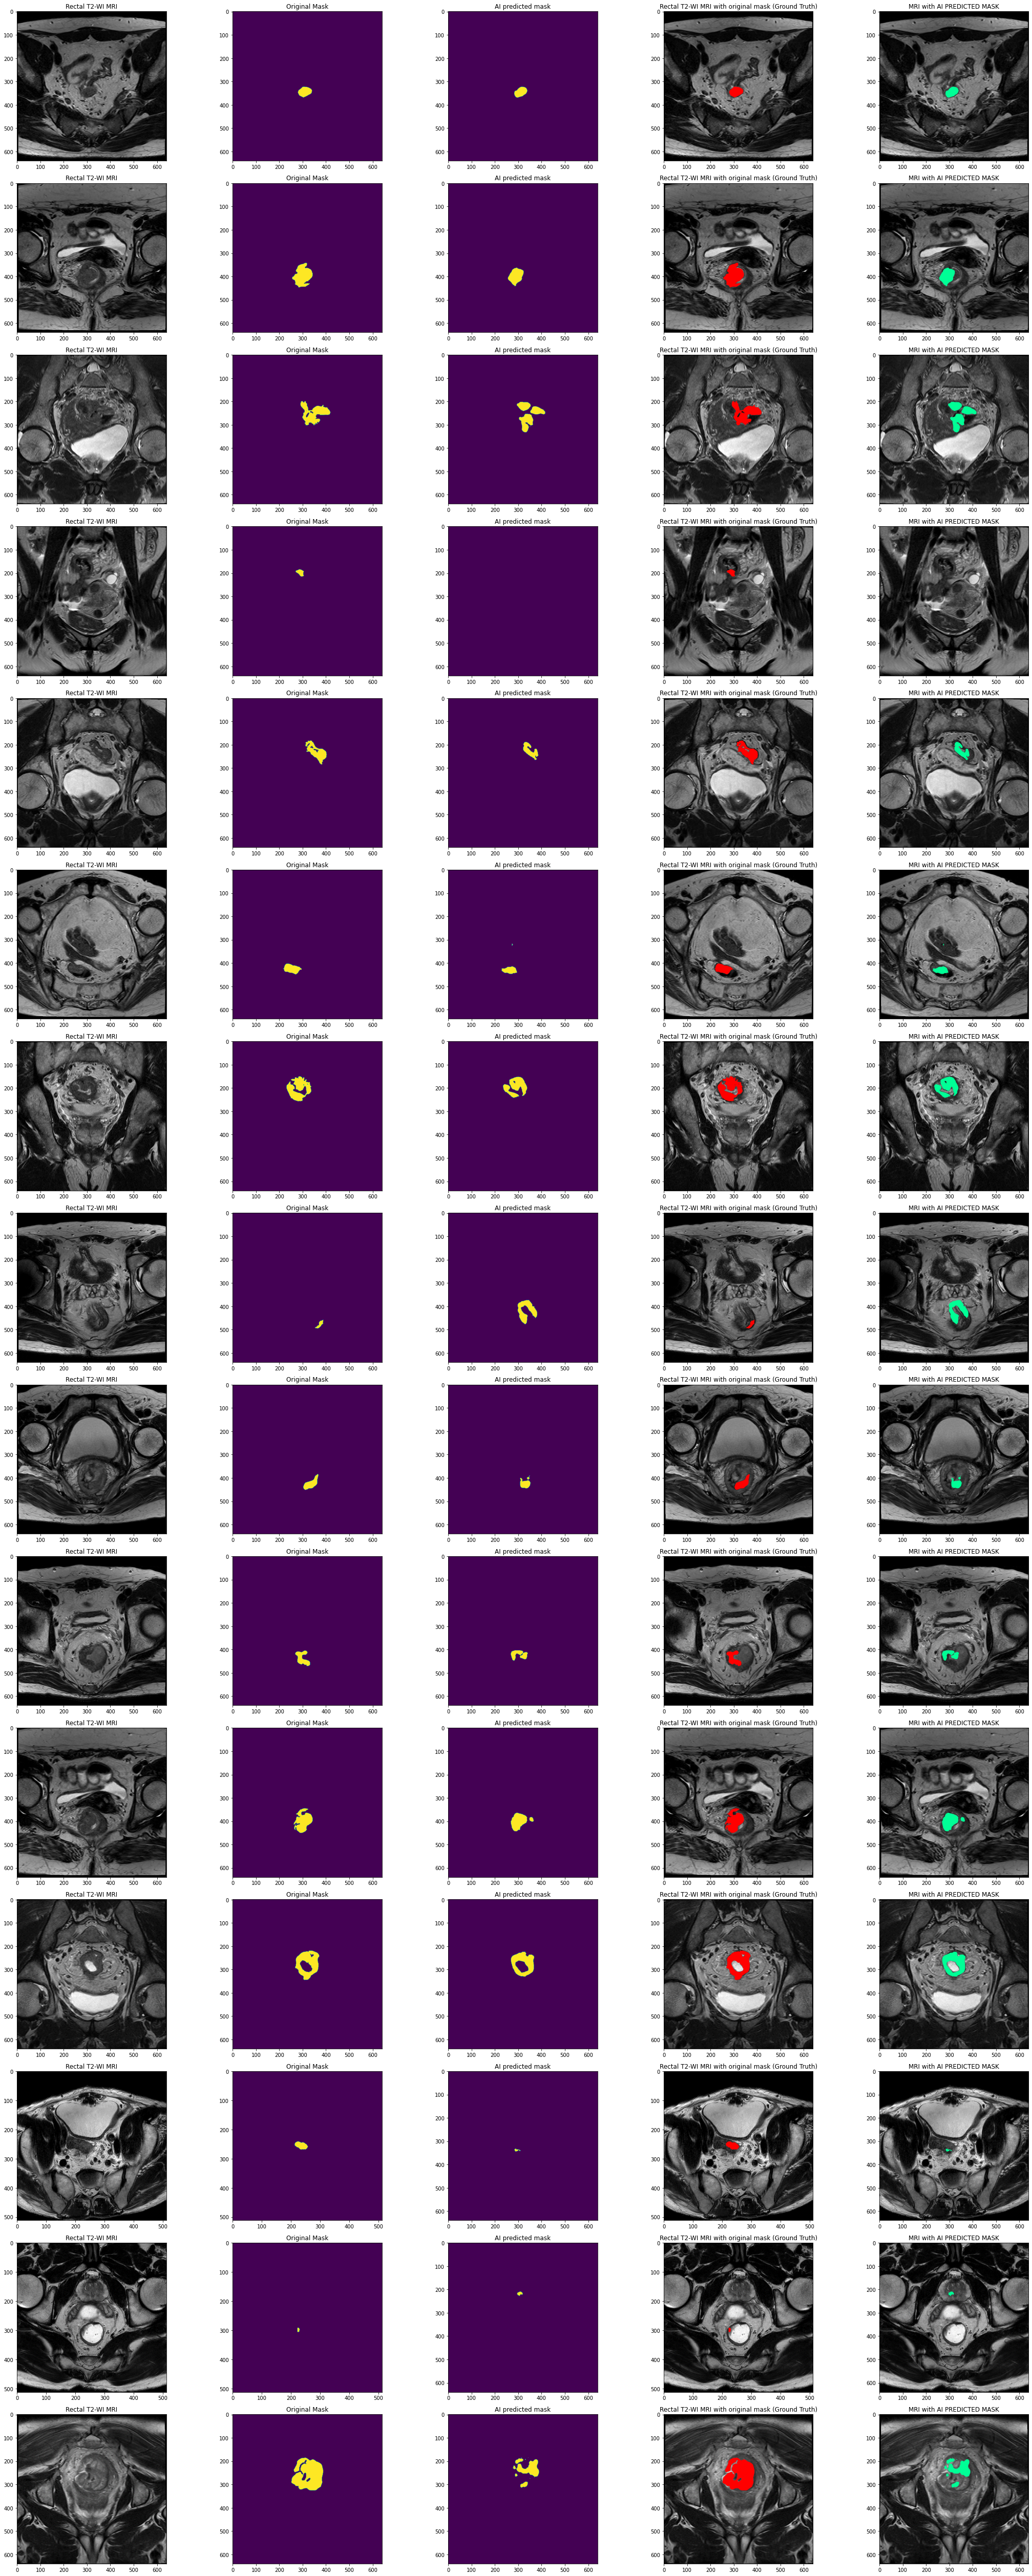

In [24]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Rectal T2-WI MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.argmax(np.array(df_pred.predicted_mask[i]).squeeze().round(),-1)
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Rectal T2-WI MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_ = cv2.resize(img_, dsize=(640, 640), interpolation=cv2.INTER_AREA)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout() 